In [162]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from accelerate import Accelerator


In [163]:
import numpy as np
import os

In [164]:
# Load the data
path = 'output/alpaca-gpt4_10000_local1_c20s2_i10_b16a1_l512_r8a16_20240904104512/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses.append(loss)

losses

[1.2586470603942872,
 1.233310604095459,
 1.234562873840332,
 1.141893196105957,
 1.1671799659729003,
 1.1914943695068358,
 1.1486240386962892,
 1.1637863159179687,
 1.181260585784912,
 1.1910924911499023,
 1.222397518157959,
 1.1304967880249024,
 1.1977350234985351,
 1.128378677368164,
 1.1854385375976562,
 1.1831781387329101,
 1.12725887298584,
 1.1297430992126465,
 1.2026469230651855,
 1.160007381439209,
 1.1235395431518556,
 1.1269668579101562,
 1.1029908180236816,
 1.1023747444152832,
 1.1605948448181151,
 1.146131992340088,
 1.1386795043945312,
 1.1566967964172363,
 1.0632064819335938,
 1.0953787803649901,
 1.103604793548584,
 1.090519332885742,
 1.1350637435913087,
 1.1325072288513183,
 1.1060382843017578,
 1.1046870231628418,
 1.1475172996520997,
 1.1364425659179687,
 1.0985594749450684,
 1.1280107498168945,
 1.1609710693359374,
 1.1122121810913086,
 1.0766412734985351,
 1.0611449241638184,
 1.0829299926757812,
 1.1416511535644531,
 1.0815714836120605,
 1.0968894958496094,
 1.0

<Axes: >

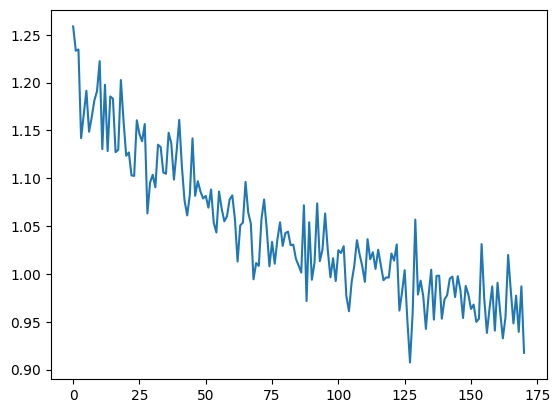

In [165]:
import seaborn as sns

sns.lineplot(x=range(len(losses)), y=losses)

In [166]:
# Load the data
path = 'output/alpaca-gpt4_10000_fedavg_c20s2_i10_b16a1_l512_r8a16_20240904104600/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses.append(loss)

losses


[1.2334733963012696,
 1.202712345123291,
 1.214587688446045,
 1.1674675941467285,
 1.2005894660949705,
 1.15072340965271,
 1.1581307411193849,
 1.185353422164917,
 1.1502472400665282,
 1.156033420562744,
 1.18402042388916,
 1.1391645908355712,
 1.1506494522094726,
 1.1527202129364014,
 1.1624462127685549,
 1.1859062671661378,
 1.1608935356140138,
 1.1662422657012939,
 1.1431221485137941,
 1.1692443370819092,
 1.1623106956481934,
 1.1595848083496094,
 1.1850672721862794,
 1.1637403964996338,
 1.122218132019043,
 1.1419722080230712,
 1.152845811843872,
 1.1293506622314453,
 1.1500260829925537,
 1.1219254016876221,
 1.1161087989807128,
 1.1273206233978272,
 1.1694227695465087,
 1.1739168643951416]

<Axes: >

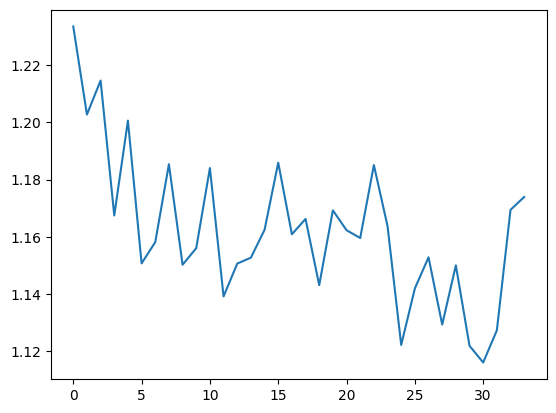

In [167]:
import seaborn as sns

sns.lineplot(x=range(len(losses)), y=losses)